In [274]:
import pandas as pd
import numpy as np
# import surprise
# from surprise import SVD
# from surprise import Dataset
# from surprise import accuracy
# from surprise import Reader
# from surprise.model_selection import GridSearchCV
# from surprise.model_selection import train_test_split
# from surprise.model_selection import cross_validate
from collections import defaultdict
from operator import itemgetter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Dropout, Dense, BatchNormalization, dot
from tensorflow.keras.optimizers import Adam

In [275]:
np.random.seed(1)
tf.random.set_seed(1)

dataset = pd.read_csv('./ml-1m/ratings.dat', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'], sep="::")
# dataset = pd.read_csv('u.data', sep='\t', header=0, encoding="ISO-8859-1", names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

C:\Users\aaron\AppData\Local\Temp\ipykernel_40864\3800801622.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv('./ml-1m/ratings.dat', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'], sep="::")


In [276]:
latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
fc_3 = Dense(10, name='fc-3', activation='relu')(fc_2_dropout)
pred_mlp = Dense(5, name='pred_mlp', activation='relu')(fc_3)
pred_mf = dot([movie_vec_mf, user_vec_mf], axes=1, name='pred-mf')
# pred_mf = tf.multiply(movie_vec_mf, user_vec_mf)
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', kernel_initializer='lecun_uniform')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.001), loss='mean_absolute_error')
#SVG(tensorflow.keras.utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       37070       ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       60410       ['user-input[0][0]']      

c:\Users\aaron\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
25006/25006 [==============================] - 47s 2ms/step - loss: 0.7789
Epoch 2/10
25006/25006 [==============================] - 47s 2ms/step - loss: 0.6946
Epoch 3/10
25006/25006 [==============================] - 46s 2ms/step - loss: 0.6660
Epoch 4/10
25006/25006 [==============================] - 47s 2ms/step - loss: 0.6489
Epoch 5/10
25006/25006 [==============================] - 46s 2ms/step - loss: 0.6383
Epoch 6/10
25006/25006 [==============================] - 49s 2ms/step - loss: 0.6304
Epoch 7/10
25006/25006 [==============================] - 52s 2ms/step - loss: 0.6247
Epoch 8/10
25006/25006 [==============================] - 51s 2ms/step - loss: 0.6198
Epoch 9/10
25006/25006 [==============================] - 49s 2ms/step - loss: 0.6159
Epoch 10/10
25006/25006 [==============================] - 49s 2ms/step - loss: 0.6124


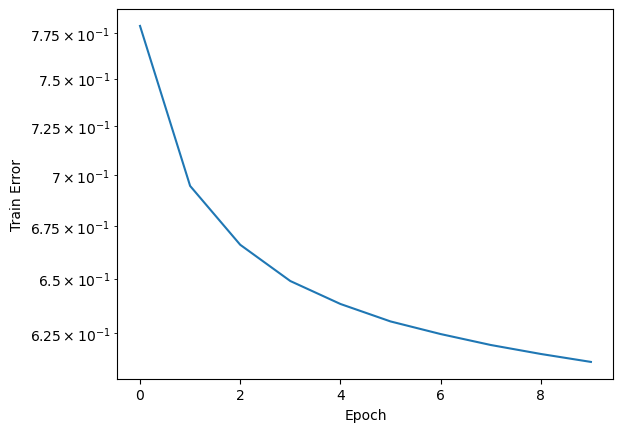

6252/6252 [==============================] - 4s 621us/step
0.7937339206082352


INFO:tensorflow:Assets written to: Trained Model\assets


INFO:tensorflow:Assets written to: Trained Model\assets


In [277]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = np.reshape(test.rating.to_numpy(), np.shape(y_hat))
mean_squared_error(y_true, y_hat, squared=False)
error = (np.subtract(y_hat, y_true) ** 2).sum() / len(test)
print(error)    

model.save('Trained Model')

In [279]:
m = list(i[0] for i in y_hat.tolist())
m.sort(reverse=True)
print(m)
print(len(list(set(test['movie_id']).difference(train['movie_id']))))
print(len(set(dataset.movie_id)))

20
3706


In [280]:
def recommend(user_id):
    unrated = list(set(dataset.movie_id).difference(set(train.loc[train['user_id'] == user_id].movie_id)))
    user = pd.Series(data=[user_id] * len(unrated))
    movie = pd.Series(data=unrated)

    y_hat = np.round(model.predict([user, movie]), decimals=2)
    pred_ratings = list(zip(unrated, (i[0] for i in y_hat.tolist())))
    pred_ratings.sort(key = lambda x: x[1], reverse=True)
    return pred_ratings[:10]